In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [3]:
%%capture
! pip install pytdc

In [4]:
import safe as sf
import datamol as dm
from safe.trainer.data_utils import get_dataset
from safe import SAFEDesign

In [5]:
designer = SAFEDesign.load_default(verbose=True, model_dir="/storage/shared_data/manu/safe/models/checkpoint-950000/")

In [7]:
from tdc import Evaluator
diversity_evaluator = Evaluator(name = 'Diversity')
validity_evaluator = Evaluator(name = 'Validity')
uniqueness_evaluator = Evaluator(name = 'Uniqueness')

In [9]:
N_SAMPLES = 1000
N_TRIALS = 10

## De novo generation

Generation of novel molecules without any constraints.

In [10]:
generated = designer.de_novo_generation(sanitize=False, n_samples_per_trial=N_SAMPLES, n_trials=N_TRIALS, how='random', max_length=150)

  0%|          | 0/10 [00:00<?, ?it/s]

In [11]:
# replace None by empty string
final_generated = [x if x is not None else '' for x in generated]

In [12]:
import pandas as pd
df = pd.DataFrame({'SMILES': final_generated})
def _sas(x):
    try:
        return dm.descriptors.sas(x)
    except:
        return None
with dm.without_rdkit_log():
    df["MOL"] = df["SMILES"].apply(dm.to_mol)
    df["clogp"] = df["MOL"].apply(dm.descriptors.clogp)
    df["qed"] = df["MOL"].apply(dm.descriptors.qed)
    df["sas"] = df["MOL"].apply(_sas)
    df["mw"] = df["MOL"].apply(dm.descriptors.mw)
df.drop(columns=["MOL"]).to_csv("10k_generated.csv", index=False)

In [34]:
df = pd.read_csv("10k_generated.csv").drop(columns=["MOL"])

In [35]:
df["SMILES"] = df["SMILES"].fillna("")

In [36]:
with dm.without_rdkit_log():
    df["MOL"] = df["SMILES"].apply(dm.to_mol)

In [38]:
final_generated = df["SMILES"].tolist()

In [83]:
import seaborn as sns
sns.set(context='notebook', font_scale=1.2)
sns.set_style("whitegrid")
sns.set_palette("Set2")



In [58]:
df = df.rename(columns={'clogp':"CLogP", "qed":"QED", "sas":"SA Score", "mw":"Molecular Weight"})

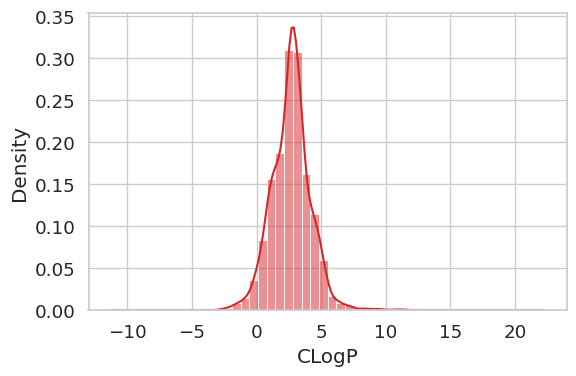

In [105]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4))

ax = sns.histplot(df.dropna(axis=0)["CLogP"], discrete=False, bins=50, kde=True, stat="density", common_norm=False, color="tab:red")
plt.tight_layout()
plt.savefig("clogp.png", dpi=300)

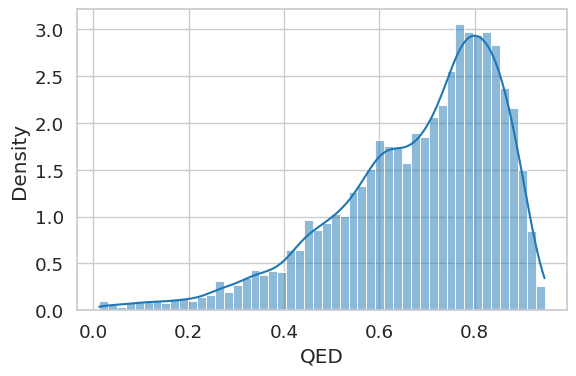

In [106]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(df.dropna(axis=0)["QED"], discrete=False, bins=50, kde=True, stat="density", common_norm=False, color="tab:blue")
plt.tight_layout()
plt.savefig("QED.png", dpi=300)

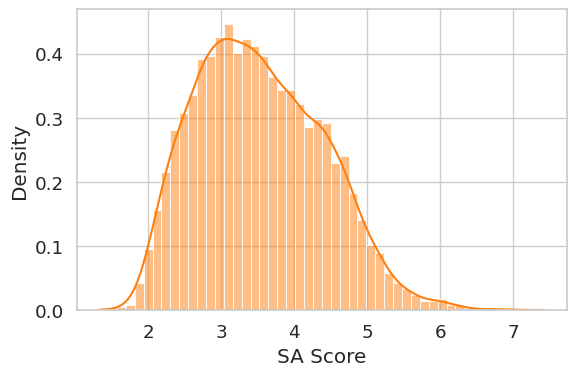

In [107]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(df.dropna(axis=0)["SA Score"], discrete=False, bins=50, kde=True, stat="density", common_norm=False, color="tab:orange")
plt.tight_layout()
plt.savefig("sas.png", dpi=300)

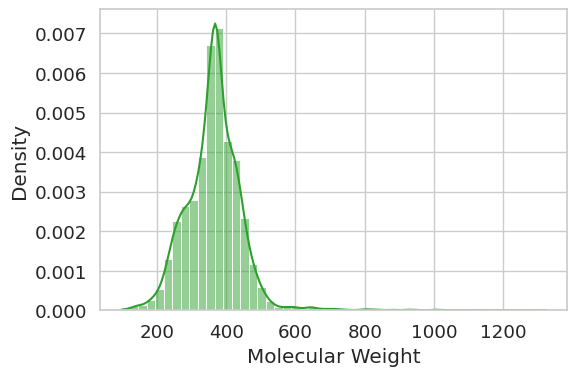

In [108]:
plt.figure(figsize=(6, 4))
ax = sns.histplot(df.dropna(axis=0)["Molecular Weight"],  discrete=False, bins=50, kde=True, stat="density", common_norm=False, color="tab:green")
plt.tight_layout()
plt.savefig("mw.png", dpi=300)

In [45]:
results = {}
results["validity@10k"] = validity_evaluator(final_generated)
results["uniqueness@10k"] = uniqueness_evaluator([x for x in final_generated if x])
results["diversity@10k"] = diversity_evaluator([x for x in final_generated if x])
results["validity@1k"] = validity_evaluator(final_generated[:1000])
results["uniqueness@1k"] = uniqueness_evaluator([x for x in final_generated if x][:1000])
results["diversity@1k"] = diversity_evaluator([x for x in final_generated if x][:1000])

[14:24:16] Unusual charge on atom 0 number of radical electrons set to zero
[14:24:17] Unusual charge on atom 0 number of radical electrons set to zero
[14:24:19] Unusual charge on atom 0 number of radical electrons set to zero
[14:24:21] Unusual charge on atom 0 number of radical electrons set to zero


In [46]:
results

{'validity@10k': 0.8813,
 'uniqueness@10k': 0.9998865312606376,
 'diversity@10k': 0.8819121227091349,
 'validity@1k': 0.898,
 'uniqueness@1k': 1.0,
 'diversity@1k': 0.882194301300815}